In [29]:
import pandas as pd
import numpy as np
import keras
from keras import layers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

from ctgan import CTGAN

from sklearn.ensemble import IsolationForest
from sklearn.preprocessing import KBinsDiscretizer


<h1>Fixing the Classification</h1>

<b>Summary from the report</b>
<ul>
<li>Remove:</li>
<ul><li>Convex_Area</li><li>Thickness</li></ul>
<li>Keep an Eye on:</li>
<ul><li>Compactness</li><li>Solidity</li><li>Aspect Ratio</li><p>They could be useless</p></ul>
<li>Remove or cap outliers for: basically every not dropped column</li>
<li>Use Synthetic Data or capping, for the distribution on:</li>
<ul><li>eccentricity</li><li>roundness</li></ul>
</ul>

In [30]:
df = pd.read_csv("Clean_Almond.csv")
df.head() 

,Length,Width,Thickness,Area,Perimeter,Roundness,Solidity,Compactness,Aspect_Ratio,Eccentricity,Extent,Convex_Area,Type
0,272.553253,227.940628,127.759132,22619.0,643.813269,0.460467,0.973384,1.458265,1.565795,0.798147,0.681193,23237.5,MAMRA
1,340.942719,234.188126,128.199509,23038.0,680.984841,0.451983,0.957304,1.601844,1.552992,0.755233,0.656353,24065.5,MAMRA
2,344.597992,229.418610,125.796547,22386.5,646.943212,0.178304,0.967270,1.487772,1.696236,0.845151,0.683620,23144.0,MAMRA
3,367.850677,232.763153,125.918808,22578.5,661.227483,0.547965,0.965512,1.540979,1.942538,0.806122,0.685360,23385.0,MAMRA
4,276.140106,230.150742,107.253448,19068.0,624.842706,0.430272,0.951450,1.629395,2.142503,0.844623,0.714800,20041.0,MAMRA


In [31]:
# everything else except the target variable
X = df.drop(["Type"], axis=1)

# have only the target variable here (dependent variable)
y_temp = df['Type']

# since we are doing classification, we have to process our target values with an encoder
# and convert them into a categorical TensorFlow/Keras -format 
le = LabelEncoder()
y_enc = le.fit_transform(y_temp)

# Converting the label into a matrix form
y = tf.keras.utils.to_categorical(y_enc)
df['Type']=y_enc

<b>Removing</b>

## NEW COMPARISON ## - Area vs Type


<Figure size 1000x600 with 0 Axes>

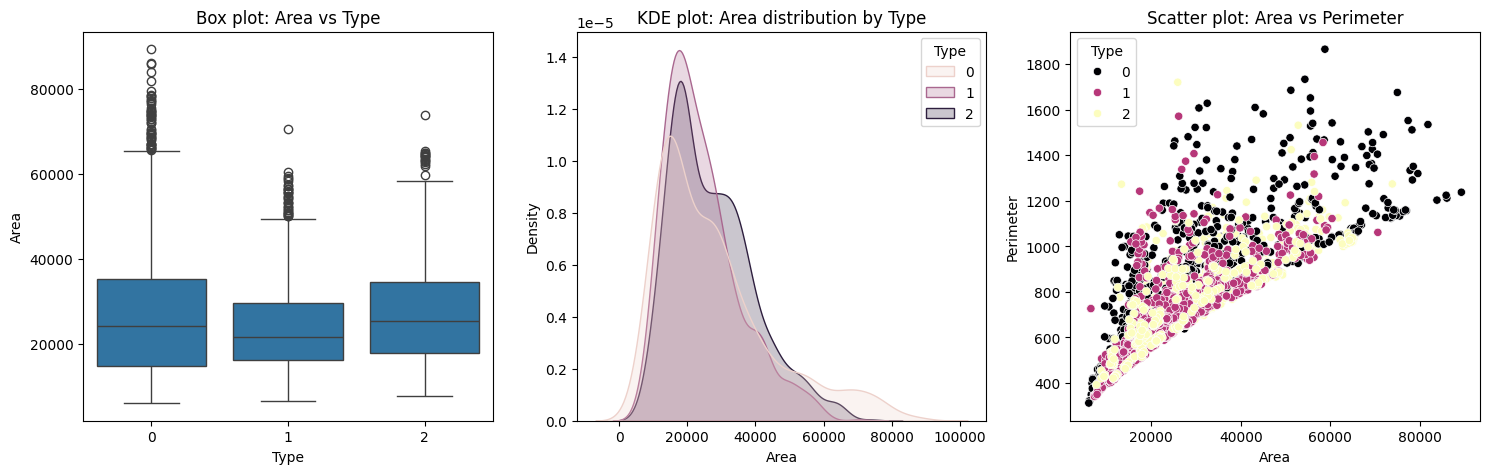

## NEW COMPARISON ## - Perimeter vs Type


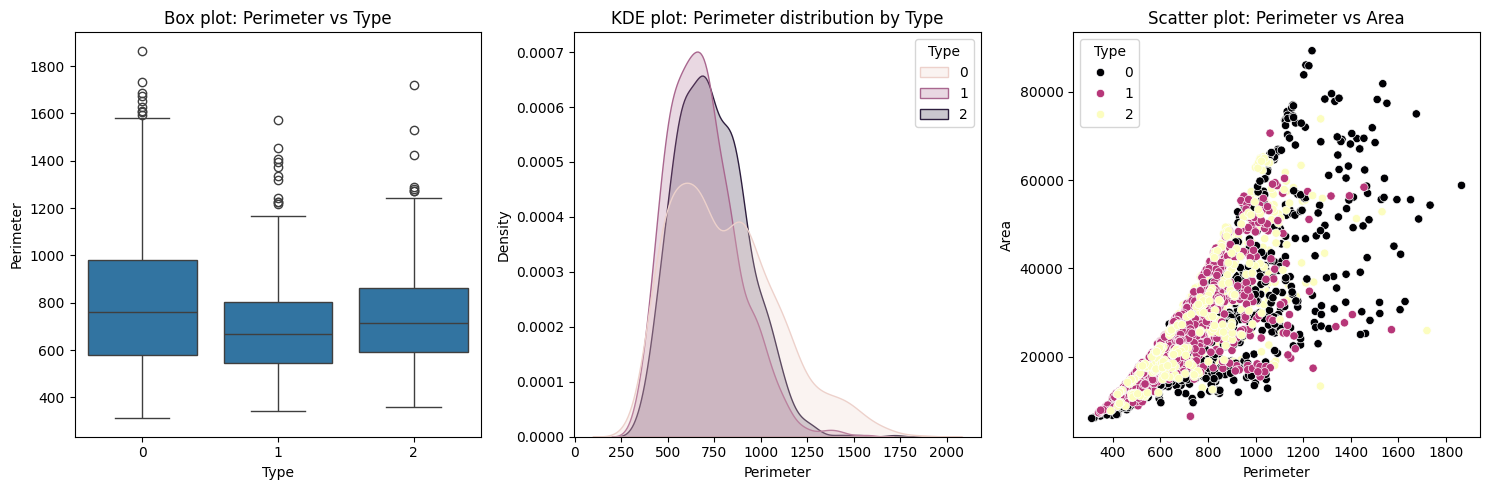

In [32]:
# CODE PARTIALLY GENERATED BY CHATGPT
# modified by instructor to have more features

# List of suspected columns for overlap
# USE SHAP, LIME, phik-matrix, correlation matrix etc to find columns that seems
# probable for having overlap, noise, redundancy, distribution problems and/or outlier problems
# try to keep the amount of variables to a small number at a time, so you don't slow down the
# process of plot generation below

#suspected_columns = ['Compactness', 'Solidity', 'Aspect_Ratio']
suspected_columns = ['Area', 'Perimeter']
target_variable = 'Type'  # The target variable

# Plot size settings
plt.figure(figsize=(10, 6))

# Iterate through suspected columns to generate box plots and scatter plots in a horizontal layout
for feature in suspected_columns:
    print(f"## NEW COMPARISON ## - {feature} vs {target_variable}")
    num_other_features = len([col for col in suspected_columns if col != feature])
    
    # Create a horizontal grid with 1 row and (1 + num_other_features + 1) columns
    fig, axes = plt.subplots(1, 2 + num_other_features, figsize=(5 * (2 + num_other_features), 5))
    
    # First plot: Box plot for the feature against the target variable
    sns.boxplot(x=target_variable, y=feature, data=df, ax=axes[0])
    axes[0].set_title(f'Box plot: {feature} vs {target_variable}')
    
    # Second plot: KDE plot for the feature, showing distribution by target variable
    sns.kdeplot(x=feature, hue=target_variable, data=df, fill=True, ax=axes[1])
    axes[1].set_title(f'KDE plot: {feature} distribution by {target_variable}')
    
    # Remaining plots: Scatter plots for the feature against every other feature
    for i, other_feature in enumerate([col for col in suspected_columns if col != feature]):
        sns.scatterplot(x=feature, palette="magma", y=other_feature, hue=target_variable, data=df, ax=axes[i + 2])
        axes[i + 2].set_title(f'Scatter plot: {feature} vs {other_feature}')
    
    # Display the entire row of plots
    plt.tight_layout()
    plt.show()

<p>More precice outliers:</p>
<p>For suspected_columns = ['Compactness', 'Solidity', 'Aspect_Ratio']</p>
<li>Compactness: over 4 = outlier</li>
<li>Solidity: under .83</li>
<li>Aspet ratio: over 2.4</li>
<p>They also dont seem to be useless since there are different values per type</p>
<br>
<p>More precice outliers:</p>
<p>For suspected_columns = ['Area', 'Perimeter']</p>
<p>They have the same impact, i will delete Permeter</p>
<li>Area over 6500</li>



In [33]:
df = df.drop('Convex_Area',axis=1)
df = df.drop('Thickness',axis=1)
df = df.drop('Perimeter',axis=1)

In [34]:
df.head()

,Length,Width,Area,Roundness,Solidity,Compactness,Aspect_Ratio,Eccentricity,Extent,Type
0,272.553253,227.940628,22619.0,0.460467,0.973384,1.458265,1.565795,0.798147,0.681193,0
1,340.942719,234.188126,23038.0,0.451983,0.957304,1.601844,1.552992,0.755233,0.656353,0
2,344.597992,229.418610,22386.5,0.178304,0.967270,1.487772,1.696236,0.845151,0.683620,0
3,367.850677,232.763153,22578.5,0.547965,0.965512,1.540979,1.942538,0.806122,0.685360,0
4,276.140106,230.150742,19068.0,0.430272,0.951450,1.629395,2.142503,0.844623,0.714800,0


<b>Cap/Outlier Removal</b>

In [35]:
#df = df[(df['Value'] >= lower_cap) & (df['Value'] <= upper_cap)]
df = df[(df['Length'] >= 100) & (df['Length'] <= 470)]
df = df[(df['Width'] >= 60) & (df['Width'] <= 270)]
df = df[(df['Area'] >= -9647) & (df['Area'] <= 62000)]
df = df[(df['Solidity'] >= 0.9) & (df['Solidity'] <= 1)]
df = df[(df['Compactness'] >= 0.5) & (df['Compactness'] <=2.8)]
df = df[(df['Aspect_Ratio'] >= 1.2) & (df['Aspect_Ratio'] <= 2.3)]
df = df[(df['Eccentricity'] >= 0.6) & (df['Eccentricity'] <= 1)]
df = df[(df['Extent'] >= 0.6) & (df['Extent'] <= 0.9)]

In [36]:
#from autoviz.AutoViz_Class import AutoViz_Class
#AV = AutoViz_Class()
#reg_av=report = AV.AutoViz(df)

<b>Distribution</b>

In [37]:
#1. ask chatgpt to fill in the almond types so that its 33% again (after the capping some was removed)
import pandas as pd

# Step 1: Check the class distribution
class_counts = df['Type'].value_counts()
print("Class counts:\n", class_counts)

# Step 2: Identify the majority and minority class counts
max_samples = class_counts.max()  # Largest class count
min_samples = class_counts.min()  # Smallest class count

# Separate data by 'Type'
dfs_by_type = {cls: df[df['Type'] == cls] for cls in class_counts.index}

# Step 3: Oversample or undersample each class to match the largest count
balanced_dfs = []

for cls, cls_df in dfs_by_type.items():
    if len(cls_df) < max_samples:
        # Oversample the minority class
        oversampled_df = cls_df.sample(n=max_samples, replace=True, random_state=42)
        balanced_dfs.append(oversampled_df)
    else:
        # Undersample the majority class
        undersampled_df = cls_df.sample(n=max_samples, random_state=42)
        balanced_dfs.append(undersampled_df)

# Step 4: Combine the balanced data
df_balanced = pd.concat(balanced_dfs, axis=0)
df=df_balanced

# Verify the new class distribution
print("New class counts:\n", df_balanced['Type'].value_counts())

# Result: df_balanced contains the balanced dataset


Class counts:
 Type
2    867
1    867
0    637
Name: count, dtype: int64
New class counts:
 Type
2    867
1    867
0    867
Name: count, dtype: int64


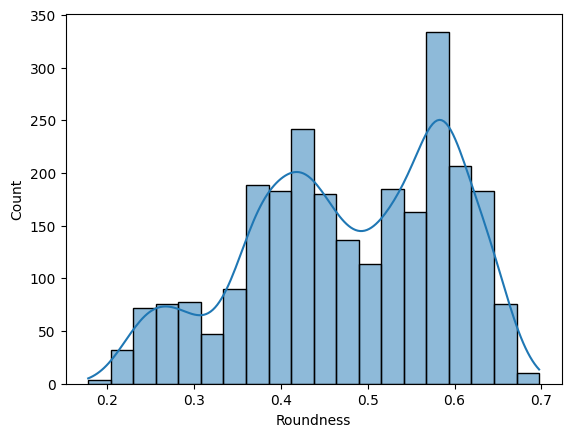

In [38]:
sns.histplot(data=df, x="Roundness", kde=True)
plt.show()


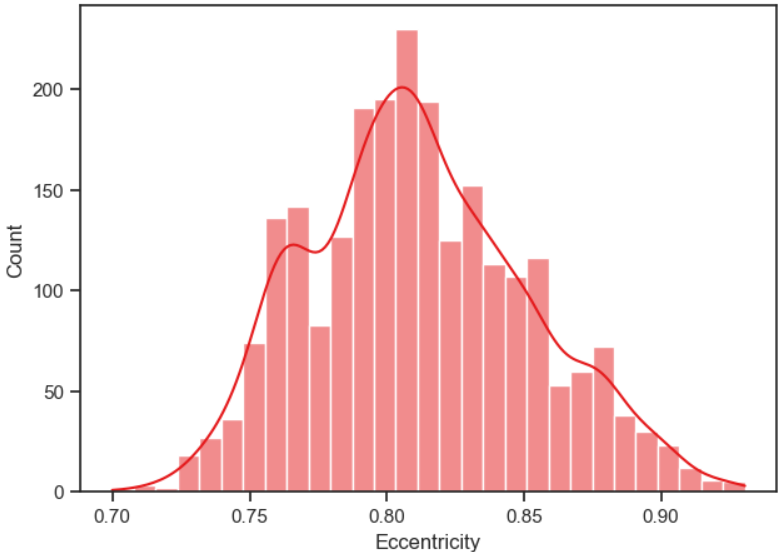
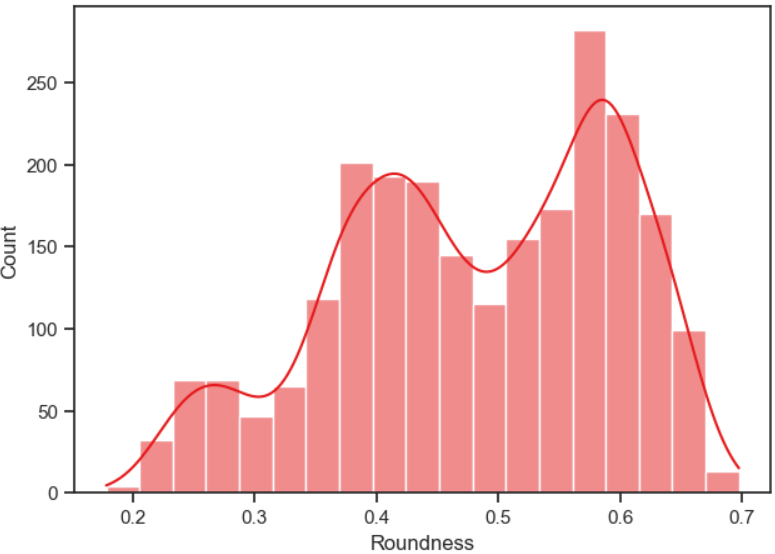

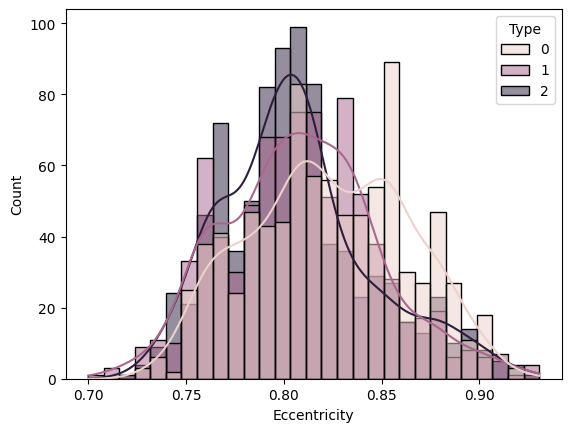

In [ ]:
sns.histplot(data=df, x="Eccentricity", hue="Type", kde=True)

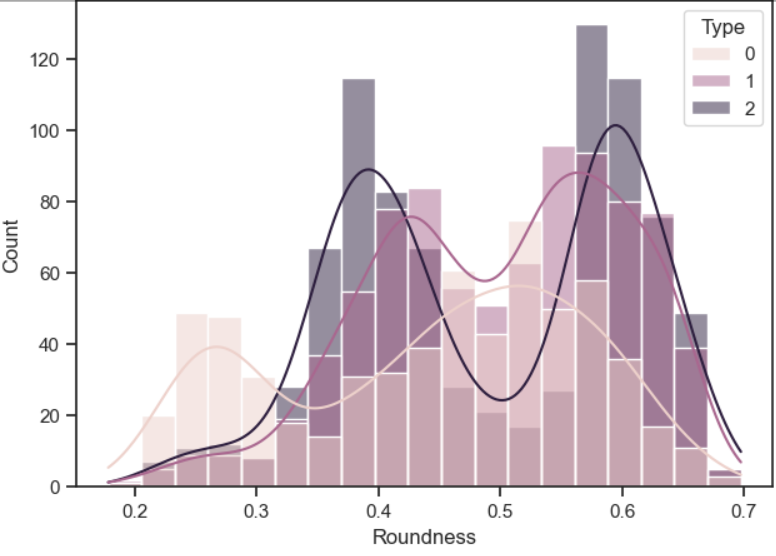
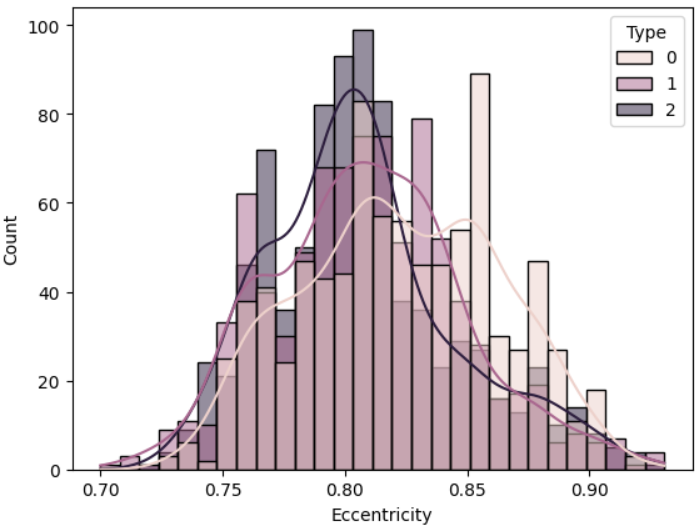

<b>Roundness</b>

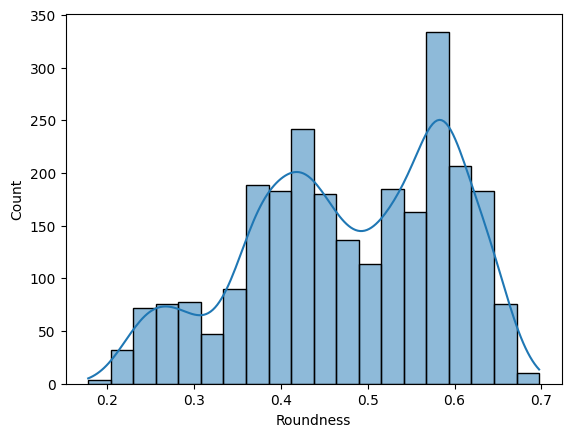

In [40]:
# this looks different since the amount of type 3 got increased
sns.histplot(data=df, x="Roundness", kde=True)
plt.show()

<b>Eccentricity</b>

<Axes: xlabel='Eccentricity', ylabel='Count'>

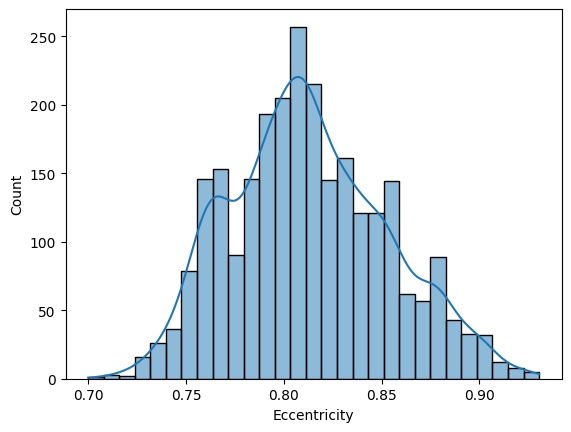

In [41]:
sns.histplot(data=df, x="Eccentricity", kde=True)

<Axes: xlabel='Eccentricity', ylabel='Count'>

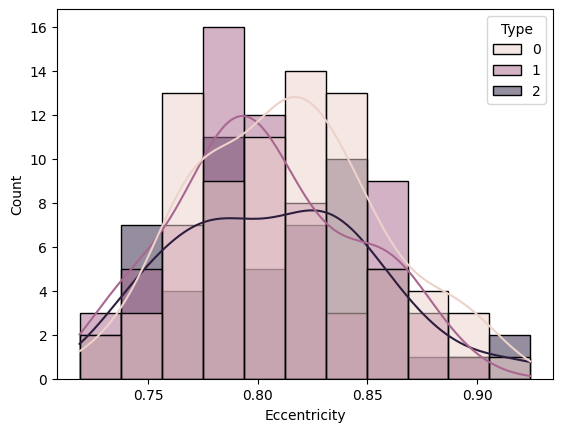

In [47]:
target = "Eccentricity"

# typical X/y split, choose target variable as needed
X = df.drop([target], axis=1)
y = df[target]

# initialize CTGAN and start training
# CTGAN is based on neural networks (GAN), that's why we have to specify epochs
ctgan = CTGAN()
ctgan.fit(df, epochs=100)

# get the data from the model
num_new_data = 200
synthetic_df = ctgan.sample(num_new_data)

sns.histplot(data=synthetic_df, x="Eccentricity", hue="Type", kde=True)

<p>This is only slightly better  because now the difference between the 3 types is smaller</p>

<Axes: xlabel='Eccentricity', ylabel='Count'>

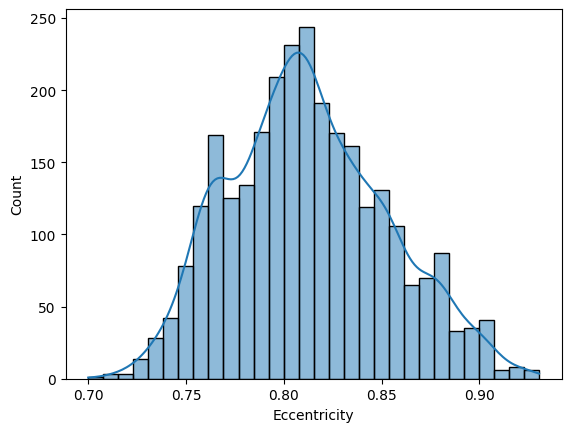

In [48]:
df = pd.concat([df, synthetic_df])
sns.histplot(data=df, x="Eccentricity", kde=True)

<b>Finished Product</b>

In [43]:
df.to_csv('fixed_Almond.csv', index=False)